In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd

# Parameters (from problem)
rho = 0.1
A = torch.tensor([[0.0, 1.0], [-2.0, -3.0]])
B = torch.tensor([[0.0], [1.0]])
G = torch.tensor([[0.1, 0.0], [0.0, 0.1]])
Q = torch.eye(2)
R = torch.tensor([[1.0]])

# Neural network for V(x)
class ValueNet(nn.Module):
    def __init__(self, in_dim=2, hidden=64, out_dim=1):
        super(ValueNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

# Instantiate model
model = ValueNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
def pinn_loss(x):
    x.requires_grad_(True)
    V = model(x)

    # Gradient wrt x
    gradV = autograd.grad(V.sum(), x, create_graph=True)[0]  # shape (N,2)

    # Hessian wrt x
    hessV = []
    for i in range(x.shape[1]):
        grad2 = autograd.grad(gradV[:, i].sum(), x, create_graph=True)[0]
        hessV.append(grad2.unsqueeze(1))
    hessV = torch.cat(hessV, dim=1)  # shape (N,2,2)

    # Terms of HJB
    quad_term = torch.sum(x @ Q * x, dim=1, keepdim=True)  # x^T Q x
    Ax = x @ A.T
    grad_term = torch.sum(gradV * Ax, dim=1, keepdim=True)
    control_term = -0.25 * (gradV @ B @ torch.inverse(R) @ B.T @ gradV.unsqueeze(2)).squeeze()
    trace_term = 0.5 * torch.einsum("ij,bji->b", G @ G.T, hessV).unsqueeze(1)

    # HJB residual
    hjb = rho * V - (quad_term + grad_term + control_term + trace_term)
    return (hjb**2).mean()

# Training
for epoch in range(10000):
    x_train = torch.randn(128, 2)  # sample states from normal
    loss = pinn_loss(x_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.6f}")

# After training: approximate value function and control
def V_hat(x):
    x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
    return model(x_t).item()

def u_hat(x):
    x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(0).requires_grad_(True)
    V = model(x_t)
    gradV = autograd.grad(V.sum(), x_t, create_graph=False)[0]
    return -(torch.inverse(R) @ B.T @ gradV.T).detach().numpy()


Epoch 0, Loss = 7.465419
Epoch 500, Loss = 0.467749
Epoch 1000, Loss = 0.128960
Epoch 1500, Loss = 0.183165
Epoch 2000, Loss = 0.033609
Epoch 2500, Loss = 0.017457
Epoch 3000, Loss = 0.028422
Epoch 3500, Loss = 0.009926
Epoch 4000, Loss = 0.010974
Epoch 4500, Loss = 0.029239
Epoch 5000, Loss = 0.011562
Epoch 5500, Loss = 0.015962
Epoch 6000, Loss = 0.015847
Epoch 6500, Loss = 0.017673
Epoch 7000, Loss = 0.014316
Epoch 7500, Loss = 0.011364
Epoch 8000, Loss = 0.006625
Epoch 8500, Loss = 0.006730
Epoch 9000, Loss = 0.039414
Epoch 9500, Loss = 0.011652


L1 absolute error (e1): 1.1943612251796984
Relative error (e2): 1.3839484736349892


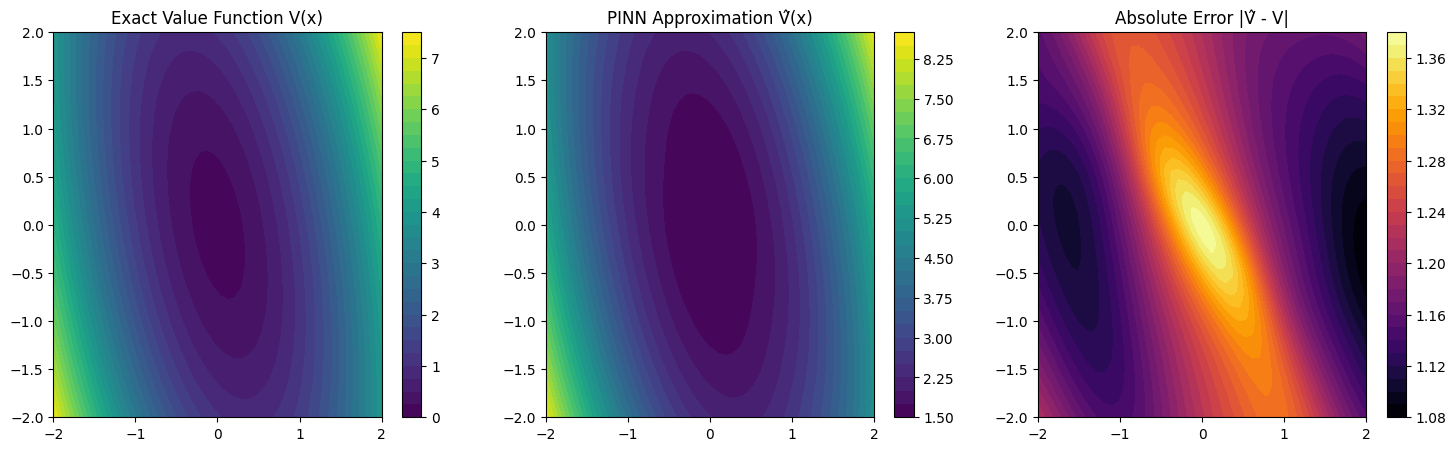

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are

# === Analytical solution ===
# CARE with discount rate
rho = 0.1
A_tilde = A.numpy() - (rho/2) * np.eye(A.shape[0])
P = solve_continuous_are(A_tilde, B.numpy(), Q.numpy(), R.numpy())
c = np.trace(P @ (G.numpy() @ G.numpy().T)) / rho

def V_exact(x):
    return x.T @ P @ x + c

def u_exact(x):
    return -(np.linalg.inv(R.numpy()) @ B.numpy().T @ (P @ x)).flatten()

# === PINN solution ===
def V_hat(x):
    x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
    return model(x_t).item()

def u_hat(x):
    x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(0).requires_grad_(True)
    V = model(x_t)
    gradV = autograd.grad(V.sum(), x_t, create_graph=False)[0]
    return (-(torch.inverse(R) @ B.T @ gradV.T)).detach().numpy().flatten()

# === Evaluation Grid ===
grid_x = np.linspace(-2, 2, 50)
grid_y = np.linspace(-2, 2, 50)
X, Y = np.meshgrid(grid_x, grid_y)

V_exact_vals = np.zeros_like(X)
V_pinn_vals = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = np.array([X[i, j], Y[i, j]])
        V_exact_vals[i, j] = V_exact(x)
        V_pinn_vals[i, j] = V_hat(x)

# === Error metrics ===
abs_err = np.abs(V_pinn_vals - V_exact_vals)
rel_err = np.abs(V_pinn_vals / V_exact_vals - 1)

e1 = np.mean(abs_err)   # L1 norm (mean absolute error)
e2 = np.mean(rel_err)   # relative error

print("L1 absolute error (e1):", e1)
print("Relative error (e2):", e2)

# === Plots ===
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

cs0 = axs[0].contourf(X, Y, V_exact_vals, levels=30, cmap="viridis")
fig.colorbar(cs0, ax=axs[0])
axs[0].set_title("Exact Value Function V(x)")

cs1 = axs[1].contourf(X, Y, V_pinn_vals, levels=30, cmap="viridis")
fig.colorbar(cs1, ax=axs[1])
axs[1].set_title("PINN Approximation V̂(x)")

cs2 = axs[2].contourf(X, Y, abs_err, levels=30, cmap="inferno")
fig.colorbar(cs2, ax=axs[2])
axs[2].set_title("Absolute Error |V̂ - V|")

plt.show()


L1 absolute error (e1): 2.07573418250468
Relative error (e2): 2.4691086414901733


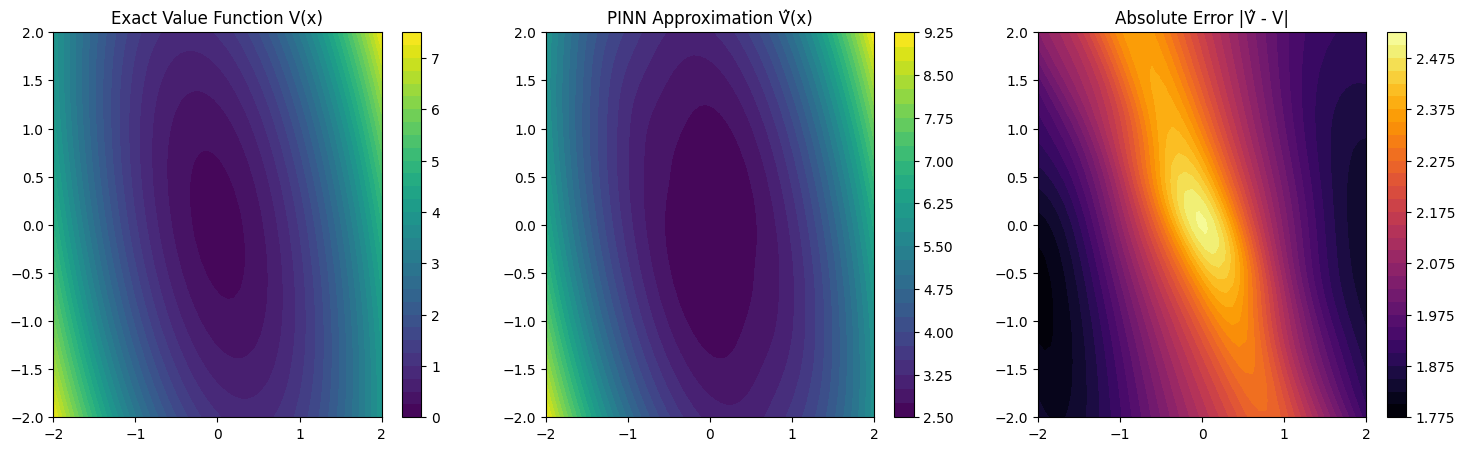

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are

# === Analytical solution ===
# CARE with discount rate
rho = 0.1
A_tilde = A.numpy() - (rho/2) * np.eye(A.shape[0])
P = solve_continuous_are(A_tilde, B.numpy(), Q.numpy(), R.numpy())
c = np.trace(P @ (G.numpy() @ G.numpy().T)) / rho

def V_exact(x):
    return x.T @ P @ x + c

def u_exact(x):
    return -(np.linalg.inv(R.numpy()) @ B.numpy().T @ (P @ x)).flatten()

# === PINN solution ===
def V_hat(x):
    x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
    return model(x_t).item()

def u_hat(x):
    x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(0).requires_grad_(True)
    V = model(x_t)
    gradV = autograd.grad(V.sum(), x_t, create_graph=False)[0]
    return (-(torch.inverse(R) @ B.T @ gradV.T)).detach().numpy().flatten()

# === Evaluation Grid ===
grid_x = np.linspace(-2, 2, 50)
grid_y = np.linspace(-2, 2, 50)
X, Y = np.meshgrid(grid_x, grid_y)

V_exact_vals = np.zeros_like(X)
V_pinn_vals = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = np.array([X[i, j], Y[i, j]])
        V_exact_vals[i, j] = V_exact(x)
        V_pinn_vals[i, j] = V_hat(x)

# === Error metrics ===
abs_err = np.abs(V_pinn_vals - V_exact_vals)
rel_err = np.abs(V_pinn_vals / V_exact_vals - 1)

e1 = np.mean(abs_err)   # L1 norm (mean absolute error)
e2 = np.mean(rel_err)   # relative error

print("L1 absolute error (e1):", e1)
print("Relative error (e2):", e2)

# === Plots ===
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

cs0 = axs[0].contourf(X, Y, V_exact_vals, levels=30, cmap="viridis")
fig.colorbar(cs0, ax=axs[0])
axs[0].set_title("Exact Value Function V(x)")

cs1 = axs[1].contourf(X, Y, V_pinn_vals, levels=30, cmap="viridis")
fig.colorbar(cs1, ax=axs[1])
axs[1].set_title("PINN Approximation V̂(x)")

cs2 = axs[2].contourf(X, Y, abs_err, levels=30, cmap="inferno")
fig.colorbar(cs2, ax=axs[2])
axs[2].set_title("Absolute Error |V̂ - V|")

plt.show()


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# --- Problem Parameters from the document ---
rho = 0.1
A = torch.tensor([[0., 1.], [-2., -3.]], dtype=torch.float32)
B = torch.tensor([[0.], [1.]], dtype=torch.float32)
G = torch.tensor([[0.1, 0.], [0., 0.1]], dtype=torch.float32)
Q = torch.eye(2, dtype=torch.float32)
R = torch.tensor([[1.]], dtype=torch.float32)
S = torch.eye(2, dtype=torch.float32) # S = I_2 as per problem spec [cite: 55]

# Pre-calculate for efficiency
R_inv = torch.inverse(R)
GGt = G @ G.T

# --- Neural Network Definition ---
class ValueFunctionNN(nn.Module):
    def __init__(self, n_input=2, n_output=1, n_hidden=64):
        super(ValueFunctionNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_input, n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, n_output)
        )
    def forward(self, x):
        return self.network(x)

# Instantiate the network and optimizer
V_net = ValueFunctionNN()
optimizer = torch.optim.Adam(V_net.parameters(), lr=1e-3)

In [2]:
# --- Training Loop ---
epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Generate a batch of random collocation points
    x = (torch.rand(512, 2, dtype=torch.float32) - 0.5) * 6 # Sample in [-3, 3]
    x.requires_grad_(True)

    # Compute V(x) and its derivatives
    V = V_net(x)
    grad_V = torch.autograd.grad(V, x, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    
    tr_term = 0.0
    for i in range(2):
        grad_V_i = grad_V[:, i:i+1]
        hessian_row_i = torch.autograd.grad(grad_V_i, x, grad_outputs=torch.ones_like(grad_V_i), create_graph=True)[0]
        tr_term += GGt[i, i] * hessian_row_i[:, i]
    tr_term = tr_term.unsqueeze(1)

    # --- Construct the Loss Function for the Variational Inequality ---
    
    # 1. HJB Residual (L1)
    xQx = torch.sum(x @ Q * x, dim=1, keepdim=True)
    gradV_Ax = torch.sum(grad_V * (x @ A.T), dim=1, keepdim=True)
    gradV_BRB_gradV = torch.sum((grad_V @ B @ R_inv) * (grad_V @ B), dim=1, keepdim=True)
    
    hjb_residual = rho * V - (xQx + gradV_Ax - gradV_BRB_gradV + 0.5 * tr_term)

    # 2. Stopping Residual (L2)
    xSx = torch.sum(x @ S * x, dim=1, keepdim=True)
    stopping_residual = V - xSx
    
    # 3. Combine into final loss
    # We enforce L1 >= 0, L2 >= 0, and L1 * L2 = 0
    loss_continuation = torch.mean(torch.relu(-hjb_residual))
    loss_stopping_ge = torch.mean(torch.relu(-stopping_residual))
    loss_complementarity = torch.mean(hjb_residual * stopping_residual)
    
    loss = loss_continuation + loss_stopping_ge + loss_complementarity

    # Backpropagation
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

print("Training finished.")

Epoch [1000/20000], Loss: -1144980.125000
Epoch [2000/20000], Loss: -12056194.000000
Epoch [3000/20000], Loss: -48069776.000000
Epoch [4000/20000], Loss: -105034984.000000
Epoch [5000/20000], Loss: -216328832.000000
Epoch [6000/20000], Loss: -215179376.000000
Epoch [7000/20000], Loss: -268374752.000000
Epoch [8000/20000], Loss: -368208352.000000
Epoch [9000/20000], Loss: -912870016.000000
Epoch [10000/20000], Loss: -995861952.000000
Epoch [11000/20000], Loss: -1673394048.000000
Epoch [12000/20000], Loss: -1358413184.000000
Epoch [13000/20000], Loss: -1960949248.000000
Epoch [14000/20000], Loss: -1871139200.000000
Epoch [15000/20000], Loss: -3425592064.000000
Epoch [16000/20000], Loss: -781260224.000000
Epoch [17000/20000], Loss: -5236465152.000000
Epoch [18000/20000], Loss: -138676000.000000
Epoch [19000/20000], Loss: -1553165696.000000
Epoch [20000/20000], Loss: -3562804992.000000
Training finished.


<>:18: SyntaxWarning: invalid escape sequence '\h'
<>:18: SyntaxWarning: invalid escape sequence '\h'
C:\Users\Jujop\AppData\Local\Temp\ipykernel_29364\2945999221.py:18: SyntaxWarning: invalid escape sequence '\h'
  plt.title('Learned Stopping Region (where \hat{V}(x) - x^TSx \approx 0)')
c:\Users\Jujop\Documents\GitHub\ams-516\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 7 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


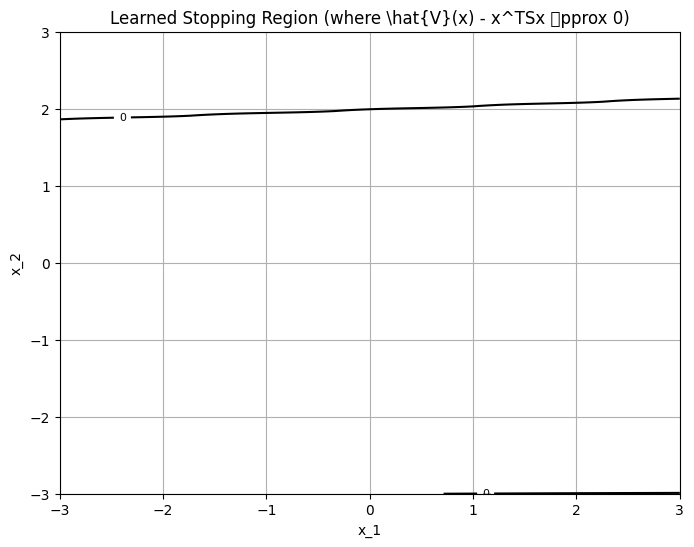

In [4]:
# Create a grid of points to evaluate the network
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)
x_grid = np.vstack([X1.ravel(), X2.ravel()]).T
x_grid_torch = torch.tensor(x_grid, dtype=torch.float32)

# Calculate V_hat and the stopping residual on the grid
V_hat = V_net(x_grid_torch).detach().numpy()
xSx = np.sum((x_grid @ S.numpy()) * x_grid, axis=1)
stopping_residual_grid = V_hat.flatten() - xSx

# The stopping region is where V_hat ≈ xSx, or stopping_residual ≈ 0
plt.figure(figsize=(8, 6))
plt.contourf(X1, X2, stopping_residual_grid.reshape(X1.shape), levels=[-0.1, 0.01], colors=['#8d75a3'], alpha=0.5)
contour = plt.contour(X1, X2, stopping_residual_grid.reshape(X1.shape), levels=[0], colors='black')
plt.clabel(contour, inline=True, fontsize=8)
plt.title('Learned Stopping Region (where \hat{V}(x) - x^TSx \approx 0)')
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.grid(True)
plt.show()

# The area shaded in purple is the learned stopping region S
# The black line is the learned stopping boundary b(x)

Ep     1 Loss=2.558089e+05 frac H<0=1.000 frac V<g=1.000
Ep   250 Loss=7.387099e+03 frac H<0=0.668 frac V<g=0.223
Ep   500 Loss=1.338911e+03 frac H<0=0.535 frac V<g=0.215
Ep   750 Loss=3.534554e+02 frac H<0=0.492 frac V<g=0.270
Ep  1000 Loss=1.391119e+02 frac H<0=0.422 frac V<g=0.355
Ep  1250 Loss=1.279945e+02 frac H<0=0.480 frac V<g=0.332
Ep  1500 Loss=8.002996e+01 frac H<0=0.453 frac V<g=0.391
Ep  1750 Loss=7.780606e+01 frac H<0=0.375 frac V<g=0.398
Ep  2000 Loss=7.052749e+01 frac H<0=0.562 frac V<g=0.414
Ep  2250 Loss=4.215455e+01 frac H<0=0.555 frac V<g=0.434
Ep  2500 Loss=3.156912e+01 frac H<0=0.590 frac V<g=0.398
Ep  2750 Loss=3.096734e+01 frac H<0=0.555 frac V<g=0.492
Ep  3000 Loss=2.345234e+01 frac H<0=0.594 frac V<g=0.469
Ep  3250 Loss=1.854155e+01 frac H<0=0.578 frac V<g=0.492
Ep  3500 Loss=1.916426e+01 frac H<0=0.543 frac V<g=0.488
Ep  3750 Loss=1.322768e+01 frac H<0=0.559 frac V<g=0.449
Ep  4000 Loss=9.121083e+00 frac H<0=0.613 frac V<g=0.461
Ep  4250 Loss=1.044622e+01 frac

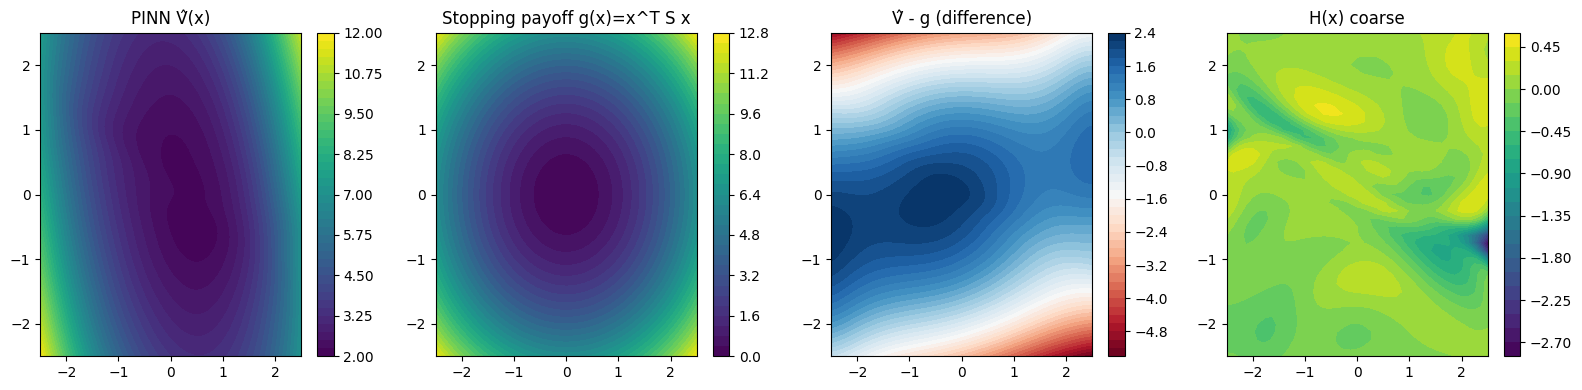

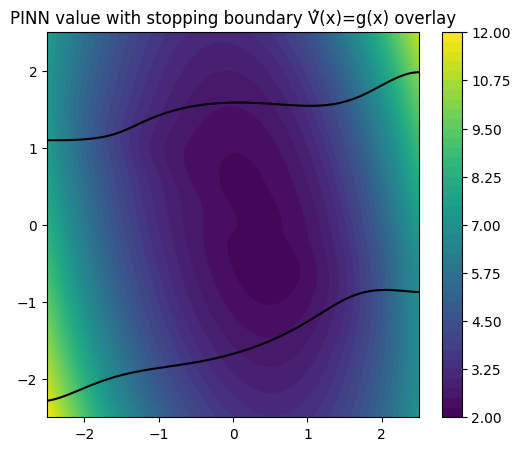

MAE in estimated continuation region: 1.4709971057938718
Relative error in continuation region: 36849.05261276723


In [6]:
# --- imports ---
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
np.random.seed(0)

# --- problem matrices (from pdf) ---
rho = 0.1
A = torch.tensor([[0.0, 1.0], [-2.0, -3.0]], dtype=torch.float32, device=device)
B = torch.tensor([[0.0], [1.0]], dtype=torch.float32, device=device)
G = torch.tensor([[0.1, 0.0], [0.0, 0.1]], dtype=torch.float32, device=device)
Q = torch.eye(2, dtype=torch.float32, device=device)
R = torch.tensor([[1.0]], dtype=torch.float32, device=device)
S = torch.eye(2, dtype=torch.float32, device=device)   # stopping payoff matrix (I2 as in problem)

# --- value net ---
class ValueNet(nn.Module):
    def __init__(self, in_dim=2, hidden=128, out_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

model = ValueNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- helper: compute gradient and Hessian for batch (manual) ---
def grad_and_hess(V, x):
    # V: (N,1) tensor, x: (N,2) requires_grad True
    gradV = autograd.grad(V.sum(), x, create_graph=True)[0]  # (N,2)
    N, d = x.shape
    # compute Hessian per sample (dxd matrix)
    hess = torch.zeros((N, d, d), dtype=x.dtype, device=x.device)
    for i in range(d):
        # gradV[:, i] is (N,), take gradient wrt x -> (N,d)
        g2 = autograd.grad(gradV[:, i].sum(), x, create_graph=True)[0]  # (N,d)
        hess[:, i, :] = g2
    # we want Hessian as (N, d, d) where entry (n,i,j) = d^2 V / dx_i dx_j
    # current hess holds rows (i, :) so it matches typical shape but we will transpose later if needed
    # To use trace(GG^T Hess) we need trace(Hess @ GG^T) per sample
    return gradV, hess

# --- HJB operator H(x; V) evaluated on a batch x ---
def H_operator(x):
    """
    x: (N,2) tensor, not detached; model will be used internally
    returns: H (N,1), V (N,1)
    """
    x = x.clone().to(device)
    x.requires_grad_(True)
    V = model(x)                       # (N,1)
    gradV, hessV = grad_and_hess(V, x) # gradV (N,2), hessV (N,2,2)
    # compute x^T Q x term
    xQx = (x @ Q) * x  # (N,2)
    quad = (xQx.sum(dim=1, keepdim=True))  # (N,1)
    # compute gradV^T A x
    Ax = (x @ A.T)     # (N,2)
    grad_term = (gradV * Ax).sum(dim=1, keepdim=True)  # (N,1)
    # control quadratic term: 0.5 * gradV^T B R^-1 B^T gradV but sign in H includes minus
    invR = torch.inverse(R)
    # compute gradV @ B -> shape (N,1)
    gradV_B = (gradV @ B).unsqueeze(-1)  # (N,1,1) if needed; simpler as (N,1)
    # compute scalar for each sample: gradV^T B R^-1 B^T gradV
    # we can compute as (gradV @ B) @ (R^-1 * (B^T @ gradV^T))
    # simpler: temp = B.T @ gradV.T -> (1, N) then multiply by invR and (gradV @ B)
    # but easiest: compute vector-matrix-vector explicitly:
    # term = (gradV @ (B @ invR @ B.T) @ gradV.unsqueeze(2)).squeeze()
    BRB = (B @ invR @ B.T)  # (2,2) but here B is 2x1 so BRB is 2x2 but rank-1
    # compute v^T M v for each batch
    # gradV is (N,2) -> (N,1,2) and (N,2,1)
    gv_row = gradV.unsqueeze(1)   # (N,1,2)
    gv_col = gradV.unsqueeze(2)   # (N,2,1)
    tmp = gv_row @ BRB.to(device) @ gv_col   # (N,1,1)
    control_quad = tmp.squeeze(-1).squeeze(-1).unsqueeze(1)  # (N,1)
    # trace term: 0.5 * tr(GG^T HessV)
    GGt = G @ G.T  # (2,2)
    # per-sample trace: tr(GGt @ HessV) = sum_ij (GGt_ij * HessV_ji) — use einsum
    # Note: our hessV has shape (N,2,2) with (n,i,j) matching d^2V/dx_i dx_j
    # So trace(GGt @ HessV) = sum_{i,j} GGt[i,j] * hessV[:, j, i] if shapes swapped,
    # but using einsum we can compute directly:
    trace_term = 0.5 * torch.einsum("ij,bji->b", GGt.to(device), hessV).unsqueeze(1)  # (N,1)
    # assemble H:
    H = rho * V - (quad + grad_term - 0.5 * control_quad + trace_term)
    return H, V

# --- loss for variational inequality ---
def vi_loss(x_batch, lambda_comp=10.0):
    """
    x_batch: (N,2) tensor
    returns scalar loss
    """
    H, V = H_operator(x_batch)  # (N,1)
    # payoff
    g = (x_batch @ S.to(device) * x_batch).sum(dim=1, keepdim=True)  # (N,1)
    # Constraints: H >= 0 ; V - g >= 0 ; complementarity H*(V-g) = 0
    c1 = torch.relu(-H)    # penalize negative H
    c2 = torch.relu(-(V - g))  # penalize negative V-g
    comp = H * (V - g)
    # loss
    loss = (c1**2).mean() + (c2**2).mean() + lambda_comp * (comp**2).mean()
    return loss, H.detach(), V.detach(), g.detach()

# --- training loop ---
n_epochs = 5000
batch_size = 256
box = 3.0  # sample state box [-box, box]^2
print_every = 250

for ep in range(1, n_epochs+1):
    x_batch = (torch.rand(batch_size, 2, device=device) * 2.0 - 1.0) * box  # uniform in [-box,box]^2
    loss, H_d, V_d, g_d = vi_loss(x_batch, lambda_comp=50.0)  # lambda_comp can be tuned
    opt.zero_grad()
    loss.backward()
    opt.step()

    if ep % print_every == 0 or ep == 1:
        # diagnostics: fraction violating constraints
        frac_H_neg = (H_d < 0).float().mean().item()
        frac_V_lt_g = ((V_d - g_d) < 0).float().mean().item()
        print(f"Ep {ep:5d} Loss={loss.item():.6e} frac H<0={frac_H_neg:.3f} frac V<g={frac_V_lt_g:.3f}")

# --- After training: evaluate on grid and compute analytic P for continuation region ---
# analytic P: solve the stochastic Riccati: A^T P + P A - P B R^{-1} B^T P + Q - rho P + P G G^T P = 0
# For this exercise we use the discounted CARE approx in Appendix 1 as the analytic baseline (continuation Riccati).
# The assignment indicates P solves A^T P + P A - P B R^{-1} B^T P + Q - rho P = 0  (stochastic adds PGG^T P)
# Use the discounted CARE from Appendix 1 (A_tilde = A - (rho/2) I) to obtain baseline P:
A_np = A.cpu().numpy()
B_np = B.cpu().numpy()
Q_np = Q.cpu().numpy()
R_np = R.cpu().numpy()
A_tilde = A_np - (rho/2)*np.eye(2)
from scipy.linalg import solve_continuous_are
P_analytic = solve_continuous_are(A_tilde, B_np, Q_np, R_np)
print("Analytic P (CARE) =\n", P_analytic)

# grid evaluation
nx = ny = 101
grid = np.linspace(-2.5, 2.5, nx)
X, Y = np.meshgrid(grid, grid)
V_pinn = np.zeros_like(X)
V_pay = np.zeros_like(X)
H_vals = np.zeros_like(X)

model.eval()
with torch.no_grad():
    for i in range(nx):
        pts = np.stack([X[i,:], Y[i,:]], axis=1)  # (ny,2)
        xt = torch.tensor(pts, dtype=torch.float32, device=device)
        Vpred = model(xt).cpu().numpy().flatten()
        V_pinn[i,:] = Vpred
        V_pay[i,:] = (pts @ S.cpu().numpy() * pts).sum(axis=1)
# evaluate H separately (requires grad) on smaller grid to compute H sign
# compute H on a coarser grid for speed
nx2 = 41
grid2 = np.linspace(-2.5, 2.5, nx2)
X2, Y2 = np.meshgrid(grid2, grid2)
H_coarse = np.zeros_like(X2)
V_coarse = np.zeros_like(X2)
g_coarse = np.zeros_like(X2)
for i in range(nx2):
    pts = np.stack([X2[i,:], Y2[i,:]], axis=1)
    xt = torch.tensor(pts, dtype=torch.float32, device=device)
    H_val, V_val = H_operator(xt)
    H_coarse[i,:] = H_val.detach().cpu().numpy().flatten()   # add .detach()
    V_coarse[i,:] = V_val.detach().cpu().numpy().flatten()   # add .detach()
    g_coarse[i,:] = (pts @ S.cpu().numpy() * pts).sum(axis=1)


# compute stopping contour where V_pinn ~ payoff
diff = V_pinn - V_pay

# --- plots ---
plt.figure(figsize=(16, 4))
plt.subplot(1,4,1)
plt.contourf(X, Y, V_pinn, 40)
plt.title("PINN V̂(x)")
plt.colorbar()

plt.subplot(1,4,2)
plt.contourf(X, Y, V_pay, 40)
plt.title("Stopping payoff g(x)=x^T S x")
plt.colorbar()

plt.subplot(1,4,3)
plt.contourf(X, Y, diff, 40, cmap='RdBu')
plt.title("V̂ - g (difference)")
plt.colorbar()

plt.subplot(1,4,4)
# show sign of H on coarse grid
plt.contourf(X2, Y2, H_coarse, 30)
plt.title("H(x) coarse")
plt.colorbar()

plt.tight_layout()
plt.show()

# plot stopping boundary estimate: contour V̂ - g = 0
plt.figure(figsize=(6,5))
cs = plt.contour(X, Y, V_pinn - V_pay, levels=[0.0], colors='k')
plt.contourf(X, Y, V_pinn, 40)
plt.title("PINN value with stopping boundary V̂(x)=g(x) overlay")
plt.colorbar()
plt.show()

# --- compute simple metrics: mean absolute error in continuation region estimate ---
# analytical continuation value = x^T P x ; compute on grid and compare where V_pinn > g (i.e., continuation)
P = P_analytic
V_analytic_grid = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = np.array([X[i,j], Y[i,j]])
        V_analytic_grid[i,j] = x.T @ P @ x

cont_mask = (V_pinn - V_pay) > 1e-3  # predicted continuation region
if cont_mask.sum() > 0:
    mae_cont = np.mean(np.abs(V_pinn[cont_mask] - V_analytic_grid[cont_mask]))
    rel_cont = np.mean(np.abs(V_pinn[cont_mask]/(V_analytic_grid[cont_mask]+1e-8) - 1.0))
else:
    mae_cont = np.nan
    rel_cont = np.nan

print("MAE in estimated continuation region:", mae_cont)
print("Relative error in continuation region:", rel_cont)


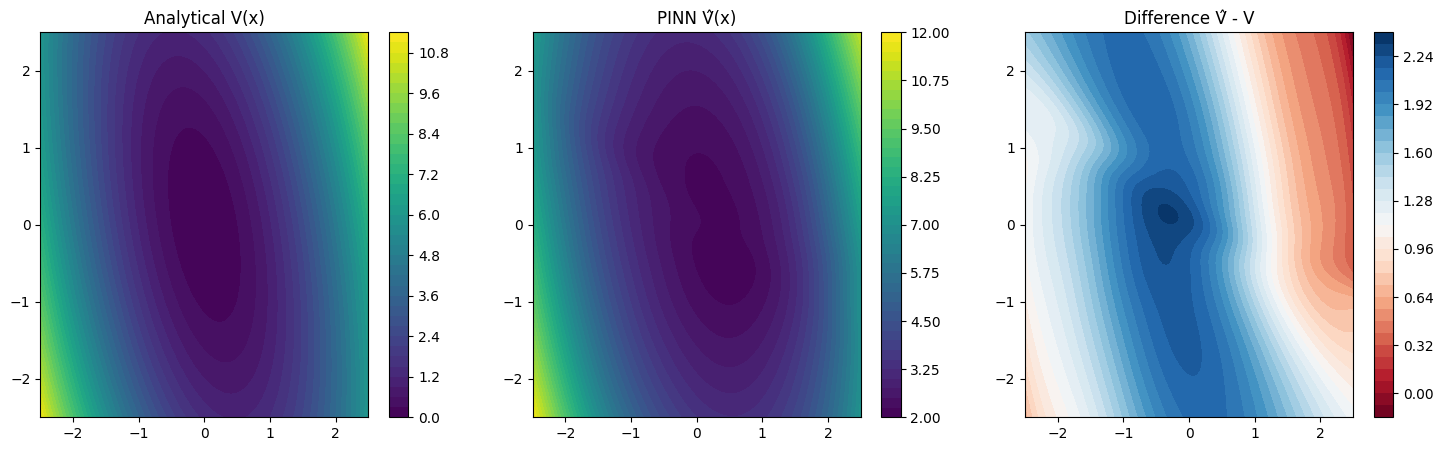

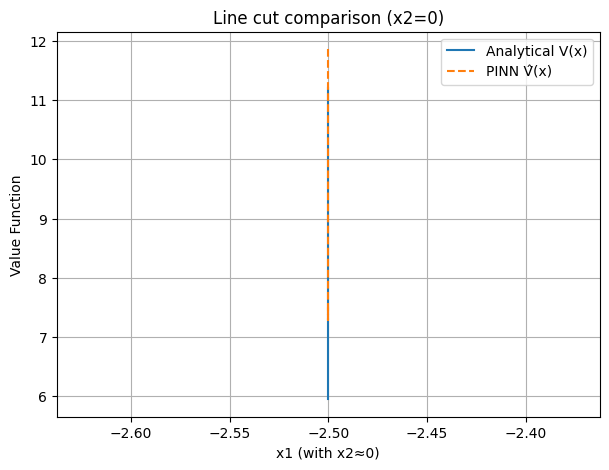

In [7]:
# --- Comparison between analytical and PINN solution ---

# 1. Compute analytic value function V_exact(x) = x^T P x
def V_exact(x):
    return x.T @ P_analytic @ x

# Evaluate on same grid as PINN
V_exact_grid = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = np.array([X[i, j], Y[i, j]])
        V_exact_grid[i, j] = V_exact(x)

# Difference
V_diff = V_pinn - V_exact_grid

# --- Plotting ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

cs0 = axs[0].contourf(X, Y, V_exact_grid, levels=40, cmap="viridis")
fig.colorbar(cs0, ax=axs[0])
axs[0].set_title("Analytical V(x)")

cs1 = axs[1].contourf(X, Y, V_pinn, levels=40, cmap="viridis")
fig.colorbar(cs1, ax=axs[1])
axs[1].set_title("PINN V̂(x)")

cs2 = axs[2].contourf(X, Y, V_diff, levels=40, cmap="RdBu")
fig.colorbar(cs2, ax=axs[2])
axs[2].set_title("Difference V̂ - V")

plt.show()

# --- 2. Line cut: fix y=0 and plot vs x ---
idx_y0 = np.argmin(np.abs(Y[0, :]))  # index closest to y=0
x_line = X[:, idx_y0]
V_exact_line = V_exact_grid[:, idx_y0]
V_pinn_line = V_pinn[:, idx_y0]

plt.figure(figsize=(7,5))
plt.plot(x_line, V_exact_line, label="Analytical V(x)")
plt.plot(x_line, V_pinn_line, "--", label="PINN V̂(x)")
plt.xlabel("x1 (with x2≈0)")
plt.ylabel("Value Function")
plt.title("Line cut comparison (x2=0)")
plt.legend()
plt.grid(True)
plt.show()
